# Load model

In [1]:
import numpy as np
# load keras libraies and load the MobileNet model
from keras.models import Model
from keras import applications
from keras.models import load_model

# load the trained model
from keras.utils.generic_utils import CustomObjectScope

#model_filepath = 'saved_models/model.MobileNet-3-classes.h5'
model_filepath = '../ros/src/tl_detector/saved_models/model.MobileNet-3-classes.h5'
n_classes = 3

with CustomObjectScope({'relu6': applications.mobilenet.relu6,'DepthwiseConv2D': applications.mobilenet.DepthwiseConv2D}):
    model = load_model(model_filepath)


Using TensorFlow backend.


# Load images
## NOTE: The classification is red = [1 0 0], green = [0 0 1] and yellow = [0 1 0], so the red light images must be in a folder which comes alphabetically before the yellow folder and the yellow folder name must be alphabetically before the green one!
Example:
red light images in sub-folder "0.red"

yellow light images in sub-folder "1.yellow"

green light images in sub-folder "2.green"


In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load the train, test datasets
def load_dataset(path):
#    data = load_files(path, categories=['red', 'yellow', 'green'])
    data = load_files(path)
    X = np.array(data['filenames'])
    y = np_utils.to_categorical(np.array(data['target']), n_classes)
    print(data['target'])
    print(data['target_names'])
    return X, y

# load the train, test dataset
X_test, y_test = load_dataset('test_data')
# load the list of signal names
signal_names = [item[10:-1] for item in sorted(glob("test_data/*/"))]

print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)
print('There are %d total images' % X_test.shape[0])
print('There are %d kinds of signals:' % y_test.shape[1])
print('\t\t\t',signal_names)

# transform the input data to tensors
from keras.preprocessing import image
from tqdm import tqdm
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
# to tensors and normalize it
test_tensors = paths_to_tensor(X_test).astype('float32')/255

# get index of predicted signal sign for each image in test set
signal_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
# print out test accuracy
test_accuracy = 100*np.sum(np.array(signal_predictions)==np.argmax(y_test, axis=1))/len(signal_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)


  9%|███▋                                       | 7/81 [00:00<00:01, 63.06it/s]

[0 0 2 0 2 2 1 2 2 0 1 1 1 1 2 0 2 2 1 0 2 0 2 2 1 1 0 2 0 2 0 0 2 1 2 1 0
 0 2 0 0 1 1 2 0 1 2 0 2 0 1 2 1 0 1 0 0 2 0 0 2 0 1 0 2 0 1 1 1 2 2 0 2 1
 0 0 2 2 2 1 1]
['0.red', '1.yellow', '2.green']
Shape of X_test:  (81,)
Shape of y_test:  (81, 3)
There are 81 total images
There are 3 kinds of signals:
			 ['0.red', '1.yellow', '2.green']


100%|██████████████████████████████████████████| 81/81 [00:00<00:00, 86.10it/s]


Test accuracy: 93.8272%


In [3]:
print(test_tensors.shape)
img = test_tensors[0]
print(img.shape)
# get index of predicted signal sign for each image in test set
signal_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
print(signal_predictions)

(81, 224, 224, 3)
(224, 224, 3)
[0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 1, 1, 1, 0, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 1, 1, 0, 2, 0, 2, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 1, 2, 0, 2, 0, 0, 2, 1, 0, 1, 0, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 2, 2, 2, 1, 1]


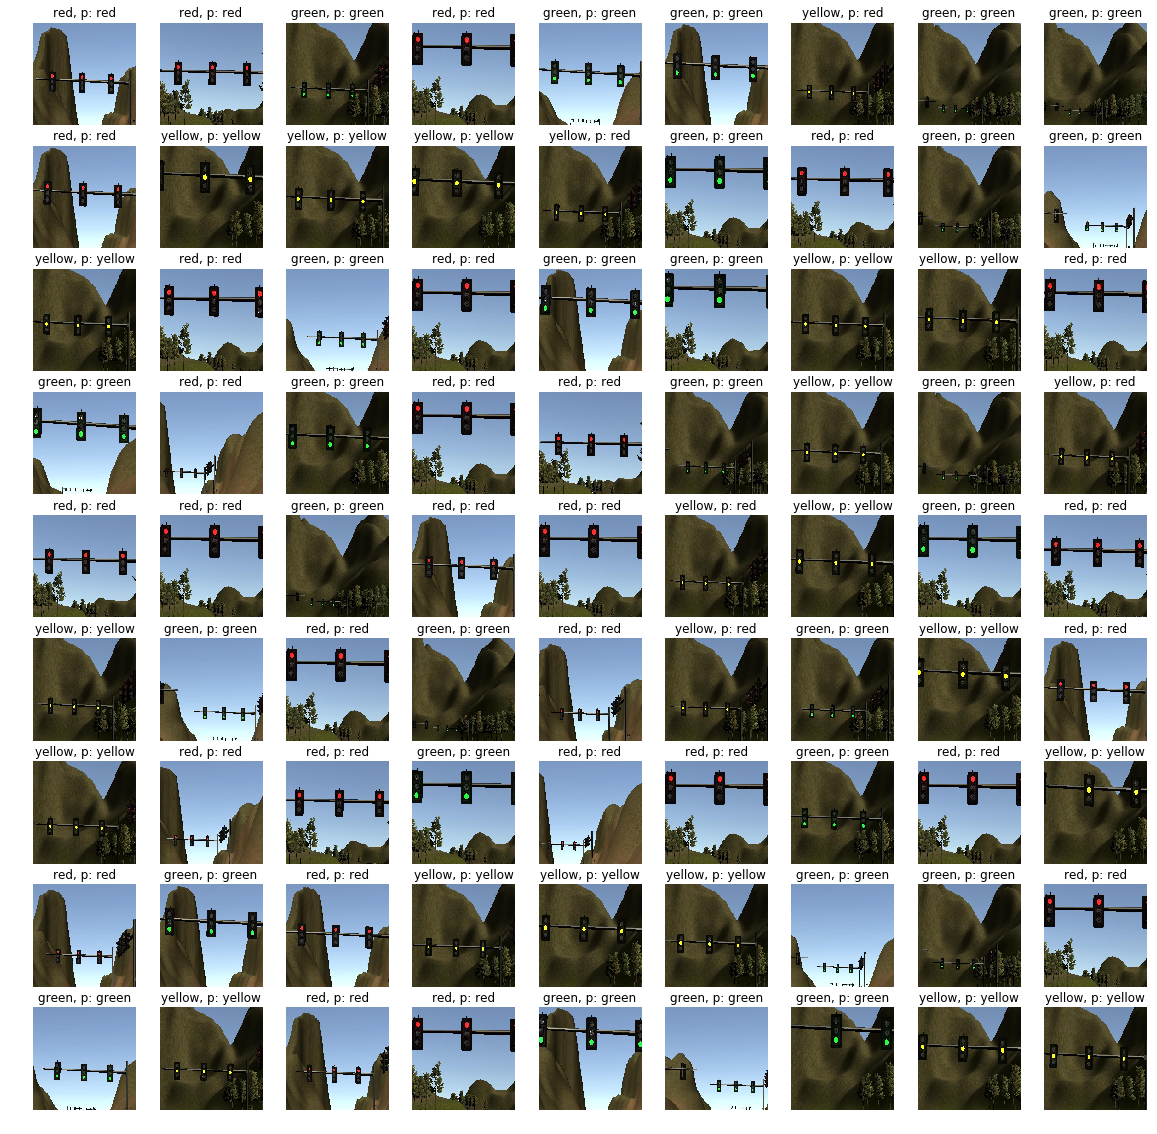

In [4]:
import math
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

imageCount = X_test.shape[0]
rows = math.ceil(math.sqrt(imageCount))
cols = math.ceil(math.sqrt(imageCount))

imageDict = {}
# gets the sign names for the labels
imageDict[0] = 'red'
imageDict[1] = 'yellow'
imageDict[2] = 'green'

images = []

plt.figure(figsize=(20,20))


for index in range(imageCount):
    plt.subplot(rows, cols, index+1)
    plt.title("{}, p: {}".format(imageDict[np.argmax(y_test[index])], imageDict[signal_predictions[index]]))
    plt.axis('off')
    image = test_tensors[index]
    plt.imshow(image)
    images.append(image)
